## K-nearest neighbors, Softmax classifier, Image classification Project (10 pts)
<em>University of Virginia - Introduction to Computer Vision - Fall 2019 - Vicente Ordonez - vicente@virginia.edu</em><br/><br/>

In this project assignment we will apply our knowledge of machine learning to design an image classifier. We will als use a new library for tensor (matrix) manipulation [Pytorch](http://pytorch.org/) instead of numpy. If you're running Google Colab, then it is already installed but if you're using a locally hosted Jupyter notebook you will probably need to install pytorch. It is like numpy, you can slice, index, and do matrix operations. But pytorch has a lot of other additional features that we will exploit in this and the following final assignment. First we will try pytorch with a few examples and once that is done we will move on to image classification.



### 1. Pytorch Introduction
At its core Pytorch is a tensor manipulation library similar to numpy. We will see here a few examples of how to use it. First, let's install pytorch using pip3. If you are working offline on a supported platform you can run this in the command line.

#### **1.1 Basic Tensor Operations:** 
Let's create some image tensors and perform some operations.

In [1]:
import torch

# Let's create two matrices of size 4x4 and full of ones.
a = torch.ones(4, 4)
b = torch.ones(4, 4)

# Just like in numpy you can get the shape of a tensor.
print(a.shape)
print(b.shape)

# Just like in numpy operations are overloaded to avoid for-loops.
c = 3 * a + 2 * (b  ** 2)
# Set the elements in thhe middle of the matrix as zero.
c[1:3, 1:3] = 0  # Indexing works like numpy as well.
# Print the matrix.
print(c)

# Compute a dot product between the two matrices.
sum_value = torch.sum(a * b) # Element-wise multiplication and sum.

# The following should print a scalar but in Pytorch scalars
# are tensors of empty size. # Take not this is different than Numpy.
print(sum_value)
print(sum_value.shape)

# Using .item() extracts the raw number from the Pytorch scalar tensor.
print(sum_value.item())

torch.Size([4, 4])
torch.Size([4, 4])
tensor([[5., 5., 5., 5.],
        [5., 0., 0., 5.],
        [5., 0., 0., 5.],
        [5., 5., 5., 5.]])
tensor(16.)
torch.Size([])
16.0


#### **1.2 Image Transformations:** 
Let's see an example of how to read an image into a pytorch tensor, resize it so that its longest side is 256 and then extract the 224x224 center crop. Then convert back to numpy and display. Note: I took the picture of this cat at the Edgar Allan Poe's Museum in Richmond.

torch.Size([4, 224, 224])


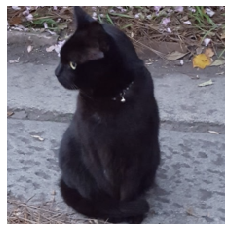

In [2]:
import torch, io, requests
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

img_url = 'http://www.cs.virginia.edu/~vicente/vision/black-cat.png'
response = requests.get(img_url)
img_pil = Image.open(io.BytesIO(response.content))

# These are basic image transformations included in pytorch's torchvision.
preprocess = transforms.Compose([
   # Resizes image to 256 on its smallest side.
   transforms.Resize(256),
   # Crops the center 224x224 square.
   transforms.CenterCrop(224),
   # Converts image to a torch tensor.
   transforms.ToTensor()
])

# Try commenting center-crop or resize above and see what happens.
img = preprocess(img_pil)

# Shape will be 3x224x224 because in pytorch the channel dimension in images
# is the first dimension, then height, then width.
print(img.shape)

# In order to display properly with matplotlib we have to use .permute(1,2,0)
# so that the channel dimension is the last dimension.
plt.figure()
plt.imshow(img.permute(1, 2, 0)); plt.grid(False)
plt.axis('off'); plt.show()

#### **1.3 Image Processing:** 
Let's see now how to perform some basic image processing and slicing operations on this matrix.

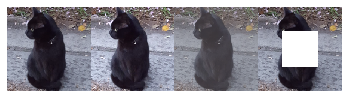

In [3]:
# Increase or decrease brightness.
# torch.clamp to avoid underflows or overflows. Keeps the values between [0,1]
# multiplication * will perform scalar * matrix multiplication
# so we avoid for-loops.
bright_img = torch.clamp(1.2 * img, 0.0, 1.0) 
dark_img = torch.clamp(0.8 * img, 0.0, 1.0)

# Crop out the center of the image.
cimg = img.clone()  # Create a full copy of the image.
# Slicing, and indexing work the same as in numpy! 
# e.g. Put zeros in the matrix center 64 pixels from all sides.
cimg[:, 64:-64, 64:-64] = 0

# Plot all results side-by-side.
plt.figure()
# torch.cat to concatenate tensors along a dimension.
out = torch.cat((img, bright_img, dark_img, cimg), 2) 
plt.imshow(out.permute(1,2,0)); plt.grid(False)
plt.axis('off'); plt.show()


**Final Comments:** For a full documentation of all the ways you can manipulate tensors use the pytorch documentation http://pytorch.org/docs/0.3.1/. Discuss in Piazza if unsure. Feel free to experiment in the above section with many tensor manipulations, e.g. you should be able to translate all that you learned to do in numpy to pytorch<br/><br/>

### 2. k-Nearest neighbors classifier

In class we studied a basic but important algorithm for classification, k-nearest neighbors. We will use k-nearest neighbors to classify images in the CIFAR-10 dataset, which is a relatively small dataset with 60 thousand images.

#### **2.1 Data Loading:** 
In this section we will load the CIFAR-10 dataset, a dataset with 50 thousand training images of size 3x32x32 each belonging to one out of 10 possible categories of objects: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. First, let's download a local copy from our extremely fault-tolerant highly-redundant zero-downtime CS servers (not).

In [4]:
!wget -nc https://www.cs.virginia.edu/~vicente/vision/cifar-10-python.tar.gz -P datalab
!tar xf datalab/cifar-10-python.tar.gz -C datalab
# Please delete the output generated by this cell.

--2019-10-26 22:24:55--  https://www.cs.virginia.edu/~vicente/vision/cifar-10-python.tar.gz
Resolving www.cs.virginia.edu (www.cs.virginia.edu)... 128.143.67.11
Connecting to www.cs.virginia.edu (www.cs.virginia.edu)|128.143.67.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘datalab/cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  15.3MB/s    in 12s     

2019-10-26 22:25:09 (13.5 MB/s) - ‘datalab/cifar-10-python.tar.gz’ saved [170498071/170498071]



#### **2.2 Data Sampling:** 
Now let's load the dataset using the pre-existing dataloader written in pytorch.

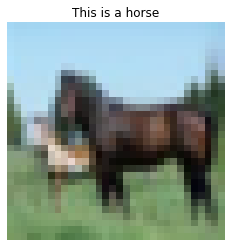

In [5]:
import torchvision
from torchvision import datasets

# This is a convenient data reader.
categories = ['airplane', 'automobile', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck']
train_data = datasets.CIFAR10('./datalab', train = True)

# This samples the 12-th image from the dataset.
# Try changing the index below to see different images in the dataset.
image, category = train_data[12]

# Display the image and its label.
# The images are 32x32 so they will look very low resolution.
plt.figure()
plt.title('This is a %s' % categories[category])
plt.imshow(image); plt.grid(False); plt.axis('off'); plt.show()

#### **2.3 Compute k-Nearest neighbors:**  
Here we will retrieve the top K = 10 nearest neighbors from all the 50k CIFAR10 images for our black-cat.jpg image and show them below. We will use the cosine similarity as the retrieval measure (see https://en.wikipedia.org/wiki/Cosine_similarity), and we will use pixels directly as our image "features". Shown below are (a) the black-cat.jpg image in 32x32 resolution, (b) the categories for the top 10 images returned, and (c) the top 10 images returned.

10000 out of 50000 done
20000 out of 50000 done
30000 out of 50000 done
40000 out of 50000 done
50000 out of 50000 done


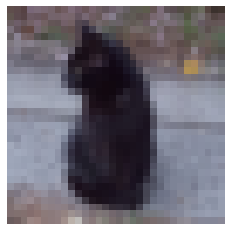

['cat', 'cat', 'cat', 'cat', 'dog', 'bird', 'bird', 'cat', 'cat', 'bird']


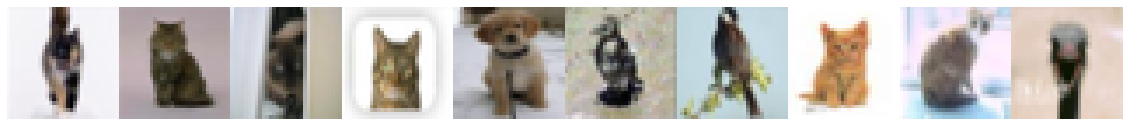

In [6]:
import io, requests

K = 10

img_url = 'http://www.cs.virginia.edu/~vicente/vision/black-cat.jpg'
response = requests.get(img_url)
cat_img = Image.open(io.BytesIO(response.content))

# This is to resize the input cat image.
preprocess_input = transforms.Compose([
   transforms.Resize(32),
   transforms.CenterCrop(32),
   transforms.ToTensor()
])

# Images in the training dataset are already 32x32.
# but we still need to convert to tensor.
preprocess_train_img = transforms.ToTensor()

cat_img_small = preprocess_input(cat_img)

# We will store distances here in this vector.
distances = torch.zeros(len(train_data))

# We will iterate over the images in the training data.
for i in range(0, len(train_data)):
  # Retrieve the image and preprocess it.
  img, label = train_data[i]
  pimg = preprocess_train_img(img)

  # Compute the cosine similarity and store it.
  v1 = pimg.reshape(32 * 32 * 3)
  v2 = cat_img_small.reshape(32 * 32 * 3)
  cos_sim = torch.sum(v1 * v2) / (v1.norm() * v2.norm())
  distances[i] = cos_sim

  # Print some logging information to know progress.
  if (i + 1) % 10000 == 0: 
    print('{0} out of {1} done'.format(i + 1, len(train_data)))

# Find the ids of the images with the highest similarity scores.
ids = distances.argsort(descending = True)

# I'm proud of the line of code below. 
# It returns the labels for the most similar images.
labels = [categories[train_data[ind][1]] for ind in ids[:10]]

# Even prouder of the line below.
# It returns and concats the most similar images.
similar_imgs = \
  torch.cat([preprocess_train_img(train_data[ind][0]) for ind in ids[:10]], 2)

# Show the cat image.
plt.figure();plt.axis('off');plt.grid(False);
plt.imshow(cat_img_small.permute(1, 2, 0));plt.show()
print(labels)

# Show the retrieved images.
plt.figure(figsize = (20,6));plt.axis('off');plt.grid(False);
plt.imshow(similar_imgs.permute(1, 2, 0));plt.show()

For the given example, the input image would be classified as cat because cat is the most frequent category in the label set for its most similar images in the dataset. Try changing the value of K or using other images.

### 3. Softmax Classifier
Here we will walk through learning a softmax classifier using pytorch's automatic differentiation capabilities (We will not need to manually derive and implement the computation of derivatives for the SGD algorithm). We will apply here several capabilities of pytorch that will be used for more complex models such as deep neural networks so pay close attention to every step.

#### **3.1 Model definition:** 
First let's see how to define a learnable model in Pytorch using the nn package. This model is untrained so the parameters such as the weight-matrix and bias-vector of the linear layer will have random parameters at this stage. i.e. if you run this cell multiple times, each time the weight and bias tensors will be populated with different values.

In [10]:
import torch
from torch import nn

# This is the softmax classifier as studied in class.
class Classifier(nn.Module):
  
    def __init__(self):
        super(Classifier, self).__init__()
        # Linear transformation layer.
        # This computes a = wx + b where:
        # a is a vector of size 10
        # x: is a vector of size 3 x 32 x 32
        # b: is a vector of size 10
        # w: is a matrrix of size 10 x (3 * 32 * 32)
        self.linear = nn.Linear(3 * 32 * 32, 10)

        # Softmax operator.
        # This is log(exp(a_i) / sum(a))
        self.log_softmax = nn.LogSoftmax(dim = 1)

    def forward(self, x):
        gx = self.linear(x)
        yhat = self.log_softmax(gx)
        return yhat
      
# Let's inspect the parameters of this classifier.
classifier = Classifier()
print('weight-matrix: ', classifier.linear.weight.shape)
print('bias-vector: ', classifier.linear.bias.shape)

# Now let's try using it on a batch 5 of images represented
# as 5 vectors of size 3 * 32 * 32.
dummy_input = torch.rand(5, 3 * 32 * 32)
out = classifier(dummy_input)
print(out.exp())

weight-matrix:  torch.Size([10, 3072])
bias-vector:  torch.Size([10])
tensor([[0.1010, 0.0777, 0.1164, 0.1168, 0.0595, 0.1005, 0.0697, 0.1495, 0.1073,
         0.1017],
        [0.1235, 0.0892, 0.0948, 0.1105, 0.0558, 0.0751, 0.0781, 0.1246, 0.1088,
         0.1396],
        [0.1231, 0.0928, 0.1076, 0.1005, 0.0471, 0.1143, 0.0645, 0.1446, 0.0934,
         0.1122],
        [0.1137, 0.0905, 0.1148, 0.1131, 0.0509, 0.1067, 0.0634, 0.1285, 0.1259,
         0.0926],
        [0.0918, 0.0783, 0.0927, 0.1589, 0.0575, 0.1025, 0.0869, 0.1010, 0.1145,
         0.1158]], grad_fn=<ExpBackward>)


#### **3.2 Data preparation:** 
Before training a machine learning model, an important step is to prepare your data, including preprocessing steps such as centering the input variables around zero.

In [85]:
from torchvision import datasets
from torch.utils.data import DataLoader

# Convert image to pytorch tensor and normalize input range.
preprocess = transforms.Compose([
    transforms.ToTensor(),
    # This centers the data around zero, and scales the values
    # so that they have unit variance. 
    # Usually an important step.
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                         (0.2023, 0.1994, 0.2010))
])

# It is possible to pass the transformation function to the data wrappers,
# so that train_data[0] returns a pytorch tensor and a label.
train_data = datasets.CIFAR10(root='./datalab', train = True, transform = preprocess)
validation_data = datasets.CIFAR10(root='./datalab', train = False, transform = preprocess)

x, y = train_data[0]
print('image: ', x.shape)
print('label: ', type(y))

image:  torch.Size([3, 32, 32])
label:  <class 'int'>


Additionally we have dataloader classes to return batches of samples as opposed to single samples from the training data which is useful to train mini-batch algorithms for training. We show below how to use one and sample from it.

In [86]:
batch_size = 128 

# It additionally has utilities for threaded and multi-parallel data loading.
trainLoader = DataLoader(train_data, batch_size = batch_size, 
                         shuffle = True, num_workers = 0)
valLoader = DataLoader(validation_data, batch_size = batch_size, 
                       shuffle = False, num_workers = 0)

# Look-up python iterators if you need: 
# https://anandology.com/python-practice-book/iterators.html
x, y = iter(trainLoader).next()
print('batch-of-images: ', x.shape)
print('batch-of-labels: ', y.shape)

batch-of-images:  torch.Size([128, 3, 32, 32])
batch-of-labels:  torch.Size([128])


#### **3.3 Model Training:** 
Here we will have our mini-batch Stochastic Gradient Descent (SGD) training loop. Make sure you understand every line of code below. Important functions to understand are nn.NLLLoss(), and loss.backward(). No code needs to be written for this section, you only need to run it.

In [87]:
# Re-initialize the classifier.
classifier = Classifier()

# Let's define the loss function or criterion.
criterion = nn.NLLLoss()

# Number of epochs is the number of times we go over the full training set.
num_epochs = 30

# Learning rate.
learningRate = 0.001

# We could also use the following pytorch utility. It supports momentum!
# optimizer = torch.optim.SGD(classifier.parameters(), lr = 0.001, momentum = 0.9)

# This is often needed to prepare model for training.
# But it does almost nothing, it doesn't train the model.
classifier.train()

# Short-cut for the model parameters.
weight = classifier.linear.weight;
bias = classifier.linear.bias;

epochs = []
train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []
# Training loop starts.
for epoch in range(0, num_epochs):
  
  correct = 0
  cumloss = 0

  # Go over all the training data one batch at a time.
  for (i, (x, y)) in enumerate(trainLoader):
    # Flatten the images in the batch to input to the classifier.
    x = x.view(x.shape[0], 3 * 32 * 32)
    
    # Compute predictions under the current model.
    yhat = classifier(x)
    
    # Compute the loss with respect to this batch.
    loss = criterion(yhat, y)
    
    # Set to zero gradients computed in previous iteration.
    if weight.grad is not None:
      weight.grad.data.zero_()
      bias.grad.data.zero_()
    # optimizer.zero_grad()
    
    # Compute the gradients for the entire model variables,
    # this includes inputs, outputs, and parameters (weight, and bias).
    loss.backward()
    
    # Now we can update the weight and bias parameters.
    weight.data.add_(-learningRate * weight.grad.data)
    bias.data.add_(-learningRate * bias.grad.data)
    # optimizer.step() # We can also use this utility from pytorch.
  
    with torch.no_grad():  # Stop recording operations for gradient computation.
      # Count the number of correct predictions on this batch.
      _, max_labels = yhat.max(1)   # Extract the max values from yhat.
      # Check if those match the correct values in y.
      # and store in cumulative variable of correct values so far during training.
      correct += (max_labels == y).sum().item() 
      # Also compute the cumulative loss so far during training.
      cumloss += loss.item()

  n = len(train_data)
  print('({0}) Training: loss = {1:.4f}, accuracy = {2:.4f}'
    .format(epoch, cumloss / n, correct / n))
  train_loss.append(cumloss / n)
  train_accuracy.append(correct / n)
  
  correct = 0
  cumloss = 0
  # Compute accuracy on the test set.
  with torch.no_grad(): # Do not record operations for grad computation.
    for (i, (x, y)) in enumerate(valLoader):
      # Flatten the images in the batch to input to the classifier.
      x = x.view(x.shape[0], 3 * 32 * 32)
      
      # Compute predictions under the current model.
      yhat = classifier(x)

      # Check if those match the correct values in y.
      # and store in cumulative variable of correct values so far.
      _, max_labels = yhat.max(1)
      correct += (max_labels == y).sum().item()
      # Also compute the cumulative loss so far.
      cumloss += loss.item()
  
  n = len(validation_data)
  print('({0}) Validation: loss = {1:.4f}, accuracy = {2:.4f}'
    .format(epoch, cumloss / n, correct / n))
  print('\n')
  epochs.append(epoch+1)

  valid_loss.append(cumloss / n)  
  valid_accuracy.append(correct / n)

(0) Training: loss = 0.0154, accuracy = 0.3121
(0) Validation: loss = 0.0157, accuracy = 0.3583


(1) Training: loss = 0.0144, accuracy = 0.3666
(1) Validation: loss = 0.0125, accuracy = 0.3715


(2) Training: loss = 0.0141, accuracy = 0.3832
(2) Validation: loss = 0.0137, accuracy = 0.3810


(3) Training: loss = 0.0140, accuracy = 0.3911
(3) Validation: loss = 0.0145, accuracy = 0.3855


(4) Training: loss = 0.0138, accuracy = 0.3973
(4) Validation: loss = 0.0155, accuracy = 0.3934


(5) Training: loss = 0.0138, accuracy = 0.4031
(5) Validation: loss = 0.0146, accuracy = 0.3853


(6) Training: loss = 0.0137, accuracy = 0.4047
(6) Validation: loss = 0.0138, accuracy = 0.3939


(7) Training: loss = 0.0136, accuracy = 0.4080
(7) Validation: loss = 0.0140, accuracy = 0.3902


(8) Training: loss = 0.0136, accuracy = 0.4090
(8) Validation: loss = 0.0140, accuracy = 0.3963


(9) Training: loss = 0.0135, accuracy = 0.4141
(9) Validation: loss = 0.0135, accuracy = 0.3972


(10) Training: loss 

**Final Comments:** What is the accuracy after training for 30 epochs. A lot of the same concepts used to train this simple linear classifier will be used to train neural network models with many layers. It is important to go over the code in this section carefully. Try changing learning rate, or number of epochs and see how this changes the training results.

## Assignment Questions (10pts)

### **1. Evaluate the k-nearest neighbors classifier (5pts):** 
Now we will load the validation images of CIFAR-10 and compute the accuracy of a k-nearest neighbors classifier (total accuracy only). Accuracy is defined as the number of images for which the k-nearest classifier predicted the correct category divided by the total number of images in the validation set. **Note:** Take into account that unlike the nearest-neighbor computed earlier in this notebook, there are 10 thousand images in the test set, so you need a fast implementation. **Hint:** You can put all 50k images in a single tensor of size (50000, 3072), all 10k images in a single tensor of size (10000, 3072), convert those tensors to numpy arrays and then use scipy.spatial.distance.cdist to compute all pairwise distances at once, but take into account that this will compute distance and not similarity. I believe pytorch and numpy also have ways of computing all pairwise distances between groups of vectors -- feel free to use these other functions.

Report results for K = 1, 5, and 10 in the table below. 

Is the Softmax Classifier that we trained earlier better than the K-Nearest Neighbor Classifier? Yes | No.

In [0]:
from scipy.spatial import distance
import numpy as np
validation_data = datasets.CIFAR10('./datalab', train = False)

a = []
b = []
train_label = []
valid_label = []
for i in range(len(validation_data)):
  valid_label.append(validation_data[i][1])
  a.append(preprocess_input(validation_data[i][0]).flatten())
valid = torch.stack(a).numpy()
for i in range(len(train_data)):
  b.append(preprocess_input(train_data[i][0]).flatten())
  train_label.append(train_data[i][1])

valid = torch.stack(a)
train = torch.stack(b)

In [0]:
distances = distance.cdist(valid, train, "cosine")

In [0]:
import pickle
pickle_out =  open('mydists.pickle', 'wb')
pickle.dump({'distances': distances}, pickle_out)
pickle_out.close()
pickle_in = open("mydists.pickle","rb")
distances = pickle.load(pickle_in)

In [11]:
from scipy import stats
similarity = distances.argsort()
k1_ids = similarity[:,:1]
k5_ids = similarity[:,:5]
k10_ids = similarity[:,:10]
k1 = np.zeros(len(validation_data))
k5 = np.zeros(len(validation_data))
k10 = np.zeros(len(validation_data))
k1_correct = 0
k5_correct = 10
k10_correct = 0

k1_accu = 0
k5_accu = 0
k10_accu = 0
for i in range(len(k1_ids)):
    labels5 = [train_label[j] for j in k5_ids[i]]
    labels10 = [train_label[j] for j in k10_ids[i]]
    if valid_label[i] == train_label[k1_ids[i][0]]:
        k1_correct += 1
    if valid_label[i] == stats.mode(labels5)[0][0]:
        k5_correct += 1
    if valid_label[i] == stats.mode(labels10)[0][0]:
        k10_correct += 1
k1_accu = k1_correct/len(validation_data)
k5_accu = k5_correct/len(validation_data)
k10_accu = k10_correct/len(validation_data)
print(k1_accu, k5_accu, k10_accu)

0.3672 0.3619 0.3607


KNN is not as good as softmax model we trained earlier because softmax model has a higher accuracy

In [13]:
print("accuracy are: k = 1: {0}, k = 5: {1}, k = 10: {2}".format(k1_accu, k5_accu, k10_accu))

accuracy are: k = 1: 0.3672, k = 5: 0.3619, k = 10: 0.3607


|  | K = 1   | K = 5 | K = 10 |
|------|------|------|------|
|   all  | 36.72%|36.19%|36.07%|XX%|

### **2. Predictions using the trained Softmax Classifier (2pts):** 
Show 2 examples of images from the validation set where the model predicts the correct category, and 2 examples where the model predicts the wrong category. Show the predictions with probabilities for each class output from the trained softmax classifier. An example of a correct prediction with the model I trained is shown below.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


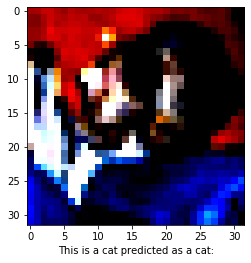

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


yhat[airplane] = 0.017110414803028107
yhat[automobile] = 0.07696904242038727
yhat[bird] = 0.033244602382183075
yhat[cat] = 0.2850061058998108
yhat[deer] = 0.01665874570608139
yhat[dog] = 0.08062894642353058
yhat[frog] = 0.23535411059856415
yhat[horse] = 0.0028369727078825235
yhat[ship] = 0.24577771127223969
yhat[truck] = 0.0064134756103158


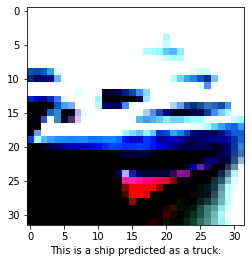

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


yhat[airplane] = 0.03329019248485565
yhat[automobile] = 0.12011323869228363
yhat[bird] = 0.00991755910217762
yhat[cat] = 0.006024471949785948
yhat[deer] = 0.002911515301093459
yhat[dog] = 0.004455128218978643
yhat[frog] = 0.002768161240965128
yhat[horse] = 0.0016424056375399232
yhat[ship] = 0.17768371105194092
yhat[truck] = 0.6411936283111572


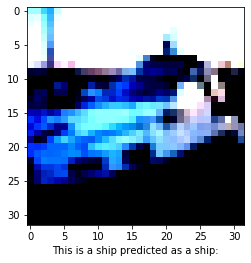

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


yhat[airplane] = 0.3017809987068176
yhat[automobile] = 0.07585528492927551
yhat[bird] = 0.015746701508760452
yhat[cat] = 0.0206296443939209
yhat[deer] = 0.002107235137373209
yhat[dog] = 0.01224631629884243
yhat[frog] = 0.0016385577619075775
yhat[horse] = 0.007459302432835102
yhat[ship] = 0.42172253131866455
yhat[truck] = 0.14081336557865143


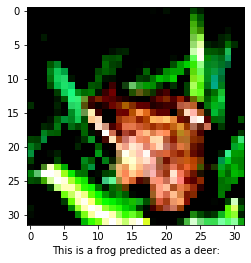

yhat[airplane] = 0.006731756497174501
yhat[automobile] = 0.047588642686605453
yhat[bird] = 0.15279623866081238
yhat[cat] = 0.03585445508360863
yhat[deer] = 0.5027884840965271
yhat[dog] = 0.07745388895273209
yhat[frog] = 0.09134777635335922
yhat[horse] = 0.04464033618569374
yhat[ship] = 0.030336137861013412
yhat[truck] = 0.010462330654263496


In [81]:
import math
counter1 = 0
counter2 = 0
with torch.no_grad(): # Do not record operations for grad computation.
# Show your examples predictions as shown below.
    for (i, (x, y)) in enumerate(valLoader):
      # Flatten the images in the batch to input to the classifier.
      img = x.squeeze()
      x = x.view(x.shape[0], 3 * 32 * 32)
      # Compute predictions under the current model.
      yhat = classifier(x)
      # Check if those match the correct values in y.
      # and store in cumulative variable of correct values so far.
      labels = yhat.squeeze()
      _, max_labels = yhat.max(1)
      if max_labels.item()==y and counter1 < 2:        
        plt.figure();plt.grid(False);
        plt.xlabel("This is a {0} predicted as a {1}:".format(categories[y], categories[max_labels.item()]))        
        plt.imshow(img.permute(1,2,0));
        plt.show()
        for i in range(len(categories)):
          print("yhat[{0}] = {1}".format(categories[i], math.e**labels[i]))
        counter1 += 1
      if max_labels.item()!=y and counter2 < 2:        
        plt.figure();plt.grid(False);
        plt.xlabel("This is a {0} predicted as a {1}:".format(categories[y], categories[max_labels.item()]))
        plt.imshow(img.permute(1,2,0));
        plt.show()
        for i in range(len(categories)):
          print("yhat[{0}] = {1}".format(categories[i], math.e**labels[i]))
        counter2 += 1
      if counter1>=2 and counter2>=2:
          break

### **3 Training analysis of Softmax Classifier (3pts):** 
Use matplotlib to plot two linecharts, one should have the training accuracy and the validation accuracy in the same figure, the second figure should have the training loss and validation loss in the same figure. The x-axis should indicate the epochs, the y-axis should indicate a range of values for either the accuracy (first figure) or the loss (second figure).

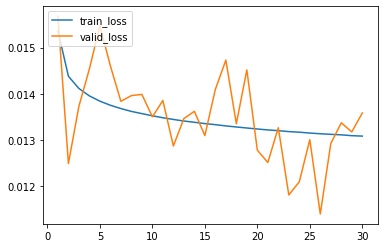

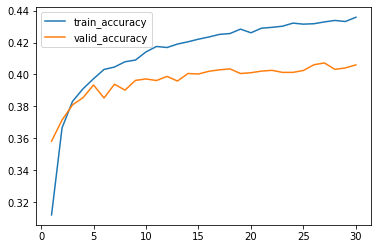

In [92]:
import numpy as np

x = epochs

plt.plot(x, train_loss)
plt.plot(x, valid_loss)
plt.legend(['train_loss', 'valid_loss'], loc='upper left')

plt.show()


plt.plot(x, train_accuracy)
plt.plot(x, valid_accuracy)
plt.legend(['train_accuracy', 'valid_accuracy'], loc='upper left')

plt.show()